![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie1.PNG)

![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie2.PNG)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie3.PNG)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie4.PNG)

In [1]:
import inspect
import shutil
import subprocess
import time
import warnings
from collections import defaultdict
from dataclasses import dataclass, field

import cupy
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda, float32, config, njit
from numba.core.errors import NumbaPerformanceWarning

config.CUDA_ENABLE_PYNVJITLINK = 1
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

## Using `GPUMatrixProcessor` for Matrix Multiplication Experiments

The `GPUMatrixProcessor` class is designed to help you experiment with and benchmark different matrix multiplication implementations on both CPU and GPU. It manages data creation, validation, benchmarking, and profiling for various approaches.

### Key Methods

- **`add_implementation(func, mem_type)`**  
    Registers a new matrix multiplication implementation.  
    - The function signature should be: `func(matrixA, matrixB, matrixC, size)`, where  
        - `matrixA`, `matrixB`, `matrixC` are 2D ndarrays (NumPy, CuPy, or Numba device arrays depending on `mem_type`)  
        - `size` is an integer specifying the matrix dimension (for square matrices)
    - `mem_type`: Memory type used by the function (`"cpu"`, `"cuda"`, or `"cupy"`).

- **`run_implementation(name, validate=False, mean_time=True, silent=False)`**  
    Executes a registered implementation by name.  
    - `name`: Name of the implementation (the function name).  
    - `validate`: If `True`, checks the result against the reference output.  
    - `mean_time`: If `True`, computes the mean execution time over several runs.  
    - `silent`: If `True`, suppresses output.

- **`run_benchmark(exclude=None)`**  
    Benchmarks all registered implementations (except those in `exclude`) across multiple matrix sizes. Results are plotted for comparison.

- **`profile_gpu_implementation(name, debug=False)`**  
    Profiles a GPU implementation using NVIDIA tools, generating a report for performance analysis.

### Typical Workflow

1. **Add your implementation:**  
     ```python
     matrix_processor.add_implementation(my_matmul_func, mem_type="cuda")
     ```

2. **Run and validate:**  
     ```python
     matrix_processor.run_implementation("my_matmul_func", validate=True)
     ```

3. **Benchmark all implementations:**  
     ```python
     matrix_processor.run_benchmark()
     ```

4. **Profile a GPU implementation:**  
     ```python
     matrix_processor.profile_gpu_implementation("my_matmul_func")
     ```

This setup allows you to easily compare different approaches and optimize your matrix multiplication code for performance on both CPU and GPU.

In [2]:
@dataclass
class GPUMatrixProcessor:
  data: dict[str, dict[str, np.ndarray]] = field(default_factory=lambda: defaultdict(dict))
  validation: np.ndarray = field(init=False)
  matrix_size: int = 1024
  benchmark: dict[str, dict[int, float]] = field(default_factory=lambda: defaultdict(dict))
  start: cuda.event = field(default_factory=cuda.event)
  end: cuda.event = field(default_factory=cuda.event)
  implementations: dict[str, callable] = field(default_factory=dict)
  implementations_mem_type: dict[str, str] = field(default_factory=dict)

  def __post_init__(self):
    self.create_data(self.matrix_size)

  def create_data(self, size: int):
    """Creates random matrices of given size."""
    self.matrix_size = size
    for matrix in ["A", "B", "C"]:  # Remove previous matrices for proper GC on the GPU
      [self.data[matrix].pop(mem, None) for mem in ["cpu", "cuda", "cupy"]]
    
    self.data["A"]["cpu"] = np.random.rand(self.matrix_size, self.matrix_size).astype(np.float32)
    self.data["B"]["cpu"] = np.random.rand(self.matrix_size, self.matrix_size).astype(np.float32)
    self.data["C"]["cpu"] = np.zeros((self.matrix_size, self.matrix_size), dtype=np.float32)
    for matrix in ["A", "B", "C"]:
      self.data[matrix]["cuda"] = cuda.to_device(self.data[matrix]["cpu"])
      self.data[matrix]["cupy"] = cupy.asarray(self.data[matrix]["cuda"])
    # Create validation data using numpy 
    self.validation = np.dot(self.data["A"]["cpu"], self.data["B"]["cpu"])

  def add_implementation(self, func: callable, mem_type: str):
    """Adds a new implementation to the processor - need to specify which type of memory to use (cpu, cuda, cupy)."""
    if mem_type not in ["cpu", "cuda", "cupy"]:
      raise ValueError("Memory type must be one of: 'cpu', 'cuda', 'cupy'.")
    self.implementations[func.__name__] = func
    self.implementations_mem_type[func.__name__] = mem_type
    if mem_type in ["cuda", "cupy"]:
      self._create_profiling_version(func.__name__)

  def run_timed_cuda(self, func: callable, *args):
    """Runs a CUDA function and times its execution using CUDA events."""
    self.start.record()
    func(*args)
    self.end.record()
    self.end.synchronize()
    return cuda.event_elapsed_time(self.start, self.end)

  def run_timed_cpu(self, func: callable, *args):
    """Runs a CPU function and times its execution using time module."""
    start = time.perf_counter_ns()
    func(*args)
    end = time.perf_counter_ns()
    return (end - start) / 1e6  # Convert to milliseconds

  def run_implementation(self, name: str, validate: bool = False, mean_time = True, silent=False):
    """Multiplies matrixA and matrixB using specified implementation."""
    func = self.implementations.get(name, None)
    if func is None:
      print(f"Implementation '{name}' not found.")
      return
    
    mem = self.implementations_mem_type[name]
    run_function = self.run_timed_cpu if mem == "cpu" else self.run_timed_cuda
    kernel_ms = run_function(func, self.data["A"][mem], self.data["B"][mem], self.data["C"][mem], self.matrix_size)
    if validate:
      if mem in ["cuda", "cupy"]:
        self.data["C"]["cuda"].copy_to_host(self.data["C"]["cpu"])
      if not np.allclose(self.data["C"]["cpu"], self.validation):
        print(f"Validation of {name} failed: Result does not match expected output.")
    if not silent:
      print(f"First execution of {name} took: {kernel_ms:.3f}ms.")
    if mean_time:
      t_mean = np.mean([run_function(func, self.data["A"][mem], self.data["B"][mem], self.data["C"][mem], self.matrix_size) for _ in range(5)])
      self.benchmark[name][self.matrix_size] = t_mean
      if not silent:
          print(f"Mean execution time of {name} is: {t_mean:.3f}ms.")

  def run_benchmark(self, exclude: list[str] = None):
    """Run all implementations with different matrix sizes and plot their execution speed."""
    for size in [256, 512, 1024, 2048, 4096]:
      self.matrix_size = size
      self.create_data(size)
      exclude = [] if exclude is None else exclude
      [self.run_implementation(name, validate=False, silent=True) for name in self.implementations if name not in exclude]

    self.plot_benchmark()
    self.create_data(1024)  # Reset to default size for further operations

  def plot_benchmark(self):
    """Plots the benchmark results for all implementations."""
    plt.figure(figsize=(10, 6))
    for name, times in self.benchmark.items():
      values = [times[s] for s in [256, 512, 1024, 2048, 4096]]
      plt.plot([256, 512, 1024, 2048, 4096], values, marker='o', label=name)
    plt.title("Matrix Multiplication Benchmark")
    plt.xlabel("Matrix Size (N x N)")
    plt.ylabel("Execution Time (ms)")
    plt.yscale('log')
    plt.legend()
    plt.grid()
    plt.show()

  def _create_profiling_version(self, func_name: str):
    """Creates a profiling version of the given function."""
    with open("template_profiling.py", "rb") as src, open(f"profiling/profiling_{func_name}.py", "wb") as dst:
      shutil.copyfileobj(src, dst)
    with open(f"profiling/profiling_{func_name}.py", "a") as prof_file:
      for name, obj in globals().items():
        if func_name in name :
            prof_file.write(f"\n{inspect.getsource(obj)}\n")
      prof_file.write(f"matrix_processor.add_implementation({func_name}, mem_type=\"{self.implementations_mem_type[func_name]}\")\n")
      prof_file.write(f"matrix_processor.run_implementation(\"{func_name}\", validate=False, mean_time=False)\n")
  
  def profile_gpu_implementation(self, name: str, debug=False):
      """Use Nvidia tools to profile the implementation."""
      result = subprocess.run(["ncu", "-f", "-o", f"profiling/ncu_{name}", 
        "--section", "ComputeWorkloadAnalysis", "--section", "InstructionStats", "--section", "LaunchStats", 
        "--section", "MemoryWorkloadAnalysis", "--section", "MemoryWorkloadAnalysis_Chart", "--section", "MemoryWorkloadAnalysis_Tables",
        "--section", "Occupancy", "--section", "SpeedOfLight", "--section", "SpeedOfLight_RooflineChart", "--section", "WarpStateStats", 
        "python", f"profiling/profiling_{name}.py"], capture_output=True, text=True)
      print(f"Check profiling/ncu_{name}.ncu-rep for profiling results.")
      if debug:
          print(f"{result.stdout}\n{result.stderr}")

#Our global object to play around with the matrices
matrix_processor = GPUMatrixProcessor()

### Task 1: Implement a Basic Matrix Multiplication with Numba

For this task, we implement a simple matrix multiplication using three nested loops and accelerate it with the `@njit` decorator from Numba. This compiles the Python code to machine code for faster execution.

After defining the function, we register it with `matrix_processor` and run it with validation. We set `mean_time=False` because this basic implementation is slow and running it multiple times would take a long time.

```python
@njit
def numba_matmul_basic(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB using Numba."""
    # ToDo: Implement the basic matrix multiplication logic

matrix_processor.add_implementation(numba_matmul_basic, mem_type="cpu")
matrix_processor.run_implementation("numba_matmul_basic", validate=True, mean_time=False)
```

In [3]:
@njit
def numba_matmul_basic(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB using Numba."""
    for y in range(size):
        for x in range(size):
            tmp = 0.0
            for k in range(size):
                tmp += matrixA[y, k] * matrixB[k, x]
            matrixC[y, x] = tmp

matrix_processor.add_implementation(numba_matmul_basic, mem_type="cpu")
matrix_processor.run_implementation("numba_matmul_basic", validate=True, mean_time=False)  # It takes a long time

First execution of numba_matmul_basic took: 8439.722ms.


### Task 2: Matrix Multiplication Using NumPy's `.dot` Function

For this task, we implement matrix multiplication using NumPy's highly optimized `np.dot` function. This approach leverages efficient low-level libraries (like BLAS) for fast computation on the CPU.

Below is the implementation and registration with `matrix_processor`:

```python
def numpy_dot(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB using Numpy dot."""
    # ToDo

matrix_processor.add_implementation(numpy_dot, mem_type="cpu")
matrix_processor.run_implementation("numpy_dot", validate=True)
```

In [3]:
def numpy_dot(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB using Numpy dot."""
    np.dot(matrixA, matrixB, out=matrixC)

matrix_processor.add_implementation(numpy_dot, mem_type="cpu")
matrix_processor.run_implementation("numpy_dot", validate=True)

First execution of numpy_dot took: 17.869ms.
Mean execution time of numpy_dot is: 8.497ms.


Let us compare the two implementations using the benchmark function of the `matrix_processor`. The values for `numba_matmul_basic` are added manually, as running this implementation takes a considerable amount of time.

If you are interested in understanding the internal optimizations that bridge the gap between the performance of `numba_matmul_basic` and `numpy.dot`, consider enrolling in the "Parallel Computing (pac)" course at FHNW. In this course, you will learn how to write highly efficient and parallel programs that leverage all available hardware features, such as caches, AVX cores, branch prediction, algorithmic optimizations, and more.

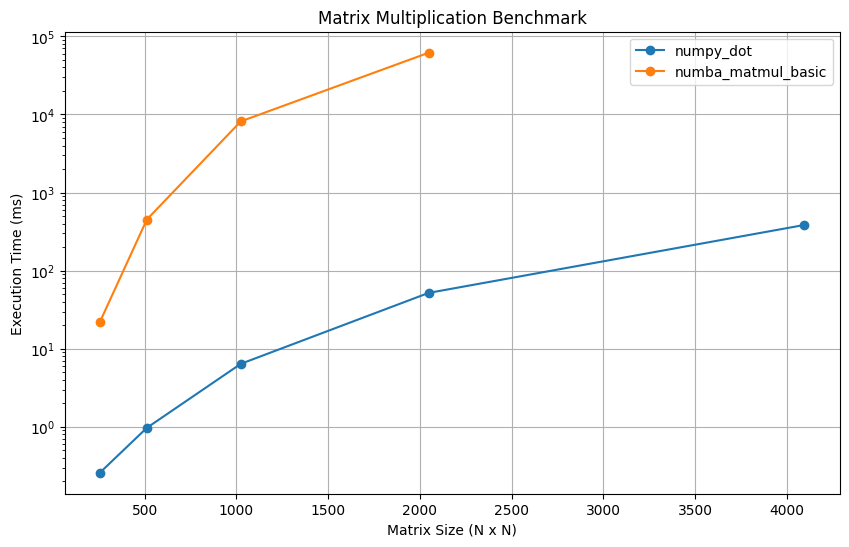

In [5]:
# Manually add benchmark results for numba_matmul_basic (AMD EPYC 7V12 64-Core Processor in Azure)
matrix_processor.benchmark["numba_matmul_basic"][256] = 22
matrix_processor.benchmark["numba_matmul_basic"][512] = 451
matrix_processor.benchmark["numba_matmul_basic"][1024] = 8140
matrix_processor.benchmark["numba_matmul_basic"][2048] = 61632
matrix_processor.benchmark["numba_matmul_basic"][4096] = None

matrix_processor.run_benchmark(exclude=["numba_matmul_basic"])

### Task 3: Basic Matrix Multiplication on the GPU with Numba CUDA

Below is the function signature for a basic GPU matrix multiplication kernel using `@cuda.jit`. Use `x, y = cuda.grid(2)` to get the thread coordinates. Implement the most basic matrix multiplication on the GPU without any optimizations.
When launching your kernel, you need to choose an appropriate block size. Consider the matrix sizes used for benchmarking ([256, 512, 1024, 2048, 4096]) and think about what block size would be efficient and compatible with these dimensions. Your choice will affect both performance and correctness, so justify your decision and ensure your kernel launch parameters work for all required matrix sizes.

```python
@cuda.jit
def cuda_matmul_gpu_basic(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB."""
    x, y = cuda.grid(2)
    # ToDo

def matmul_gpu_basic(matrixA, matrixB, matrixC, size):
    #ToDo
    cuda_matmul_gpu_basic[....](matrixA, matrixB, matrixC, size)

matrix_processor.add_implementation(matmul_gpu_basic, mem_type="cuda")
matrix_processor.run_implementation("matmul_gpu_basic", validate=True)
```

![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie15.PNG)

In [4]:
@cuda.jit
def cuda_matmul_gpu_basic(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB."""
    x, y = cuda.grid(2)

    tmp = float32(0.0)
    for k in range(size):
        tmp += matrixA[y, k] * matrixB[k, x]
    matrixC[y, x] = tmp


def matmul_gpu_basic(matrixA, matrixB, matrixC, size):
    cuda_matmul_gpu_basic[(size//32, size//32), (32,32)](matrixA, matrixB, matrixC, size)

matrix_processor.add_implementation(matmul_gpu_basic, mem_type="cuda")
matrix_processor.run_implementation("matmul_gpu_basic", validate=True)

First execution of matmul_gpu_basic took: 268.167ms.
Mean execution time of matmul_gpu_basic is: 17.889ms.


Let us rerun the benchmark. How do we perform?  
Note that the benchmarking measures only the CUDA kernel execution time, not the overhead of transferring data to and from the GPU. This data transfer time would be additional. For now, we are only interested in the plain runtime of the matrix multiplication itself.

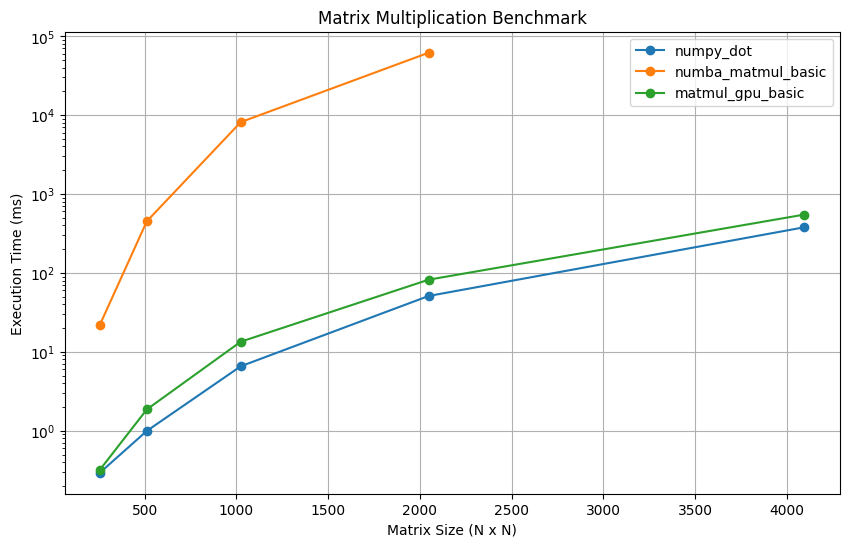

In [7]:
matrix_processor.run_benchmark(exclude=["numba_matmul_basic"])

 Is this outcome as expected? Let us discuss these results in class.

We will analyze GPU-based matrix multiplication within the context of the roofline performance model. In the upcoming tasks, we will systematically optimize our matrix multiplication implementation to better utilize GPU resources. Before proceeding, let us first examine the roofline model in detail.

![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie5.PNG)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie6.PNG)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie7.PNG)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie8.PNG)

Let us take a closer look at the implementation by utilizing profiling tools. We will use NVIDIA's Nsight Compute (`ncu`) to gather detailed performance metrics for our GPU kernel. Execute the profiling and download the resulting report file. Please note that you will need to have the NVIDIA Nsight tools installed locally in order to open and analyze the profiling report. The profiling version is using a matrix size of 2048 x 2048.

In [55]:
matrix_processor.profile_gpu_implementation("matmul_gpu_basic", debug=True)

Check profiling/ncu_matmul_gpu_basic.ncu-rep for profiling results.
==PROF== Connected to process 9292 (/usr/bin/python3.12)
==PROF== Profiling "cuda_matmul_gpu_basic[abi:v1,..." - 0: 0%....50%....
==WARNING== Launching the workload is taking more time than expected. If this continues to hang, terminate the profile and re-try by profiling the range of all related launches using '--replay-mode range'. See https://docs.nvidia.com/nsight-compute/ProfilingGuide/index.html#replay for more details.
100% - 28 passes
First execution of matmul_gpu_basic took: 14502.442ms.
==PROF== Disconnected from process 9292
==PROF== Report: /home/azureuser/src/HS25/02_Python_CUDA/profiling/ncu_matmul_gpu_basic.ncu-rep




We look at the Roofline chart first (Speed of Light Section → Roofline). We see that the Arithmetic Intensity is rather low, just slightly right from the ridge point. Furthermore, the utilization of the FP32 performance is only a few percent. So in fact, we are using the GPU very poorly, only a small fraction of its computational power is being utilized.

![GPU Roofline Basic](img/02_roofline_basic.png)

Let's have a look at the memory and bandwidth usage. We observe extremely high transfers from global memory to the L2 cache, and even more data moving from L2 to L1 cache. For reference, a single square matrix of size 2048 × 2048 using float32 occupies approximately 16 MB. So why are we transferring 1 GB or even 2 GB of data? This clearly indicates that we are not efficiently utilizing the GPU's computational resources. To address this, we need to optimize our implementation to better feed the GPU cores with work.

![GPU Memory Basic](img/03_memory_basic.png)

Let us examine the underlying hardware in greater detail and explore how its architectural characteristics influence the roofline performance model. This analysis will provide deeper insight into the interplay between computational throughput, memory bandwidth, and the practical limitations that shape observed performance in real-world scenarios.

![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie9.PNG)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie10.PNG)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie11.PNG)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie12.PNG)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie13.PNG)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie14.PNG)

To further increase performance, we leverage the shared memory of the GPU. Shared memory functions similarly to the L1 cache, but it offers explicit control within your code, allowing you to determine exactly what data is loaded and when. The following slides illustrate the classical approach of processing smaller matrix tiles on a per-threadblock basis. Each threadblock copies a tile from global memory into shared memory, and then performs matrix multiplication using this local data. This strategy significantly reduces data transfers from global memory to the cores and lowers memory access latency, as the required data is already present in shared memory (L1 cache). As a result, the roofline model shifts: during the computation loop, performance is no longer limited by HBM bandwidth, but rather by the bandwidth of shared memory (L1).

### Task 4: Matrix Multiplication with Shared Memory Tiling

Implement a matrix multiplication kernel that leverages shared memory to optimize performance, as demonstrated in the slides above. Your task is to use shared memory to store tiles from both `matrixA` and `matrixB` within each thread block. Carefully manage the loading of these tiles and synchronize threads appropriately to ensure correctness and maximize memory bandwidth efficiency. This approach should significantly reduce global memory accesses and improve the computational throughput of your GPU kernel.

```python
@cuda.jit
def cuda_matmul_shared_mem(matrixA, matrixB, matrixC, size):
    # ToDo

def matmul_shared_mem(matrixA, matrixB, matrixC, size):
    #ToDo

matrix_processor.add_implementation(matmul_shared_mem, mem_type="cuda")
matrix_processor.run_implementation("matmul_shared_mem", validate=True)
```

![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie16.PNG)

In [5]:
@cuda.jit
def cuda_matmul_shared_mem(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB."""
    sA = cuda.shared.array((32, 32), dtype=float32)
    sB = cuda.shared.array((32, 32), dtype=float32)
   
    x, y = cuda.grid(2)
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = float32(0.0)
    for i in range(size//32):
        # Preload data into shared memory
        sA[ty, tx] = matrixA[y, tx + i * 32]
        sB[ty, tx] = matrixB[ty + i * 32, x]
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(32):
            tmp += sA[ty, j] * sB[j, tx]

        cuda.syncthreads()

    matrixC[y, x] = tmp


def matmul_shared_mem(matrixA, matrixB, matrixC, size):
    """Use 8192 bytes of shared memory (32x32 tile size) for matrix multiplication."""
    cuda_matmul_shared_mem[(size//32, size//32), (32,32)](matrixA, matrixB, matrixC, size)

matrix_processor.add_implementation(matmul_shared_mem, mem_type="cuda")
matrix_processor.run_implementation("matmul_shared_mem", validate=True)

First execution of matmul_shared_mem took: 119.099ms.
Mean execution time of matmul_shared_mem is: 5.773ms.


Let us rerun the benchmark to evaluate the impact of our optimizations. Are we achieving better performance? Is the observed result in line with our expectations? Furthermore, are we utilizing the GPU resources efficiently at this stage? To answer these questions, we will profile the current implementation and analyze the findings in the NVIDIA Nsight Compute (ncu) report.

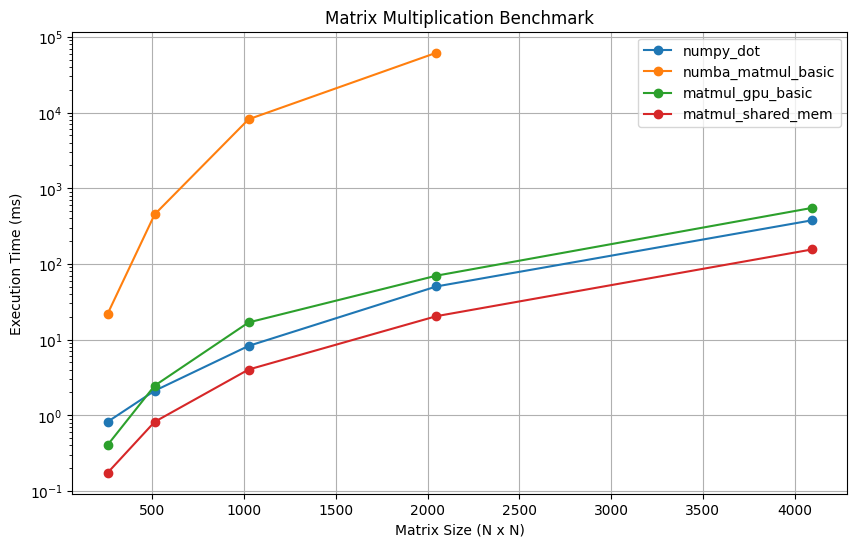

In [9]:
matrix_processor.run_benchmark(exclude=["numba_matmul_basic"])

In [73]:
matrix_processor.profile_gpu_implementation("matmul_shared_mem")

Check profiling/ncu_matmul_shared_mem.ncu-rep for profiling results.


The new roofline plot shows slight improvements. We are utilizing a greater portion of the GPU's FP32 computational capabilities compared to the basic implementation. However, the achieved performance remains significantly below the hardware's potential, indicating that further optimization is necessary to fully leverage the available resources. 

The memory plot looks very similar, indicating that we are still transferring a significant amount of duplicate data to the GPU cores during computation. This suggests that, despite the improvements from shared memory tiling, there remains substantial inefficiency in memory access patterns that limits further performance gains.

![GPU Roofline Basic](img/04_roofline_shm.png)

We observe the following message in the profiling output: *"All compute pipelines are under-utilized. Either this workload is very small or it doesn't issue enough warps per scheduler."* This indicates that our kernel is not providing sufficient work to fully occupy the available GPU resources. Upon further analysis, we notice that the Load/Store Unit (LSU) exhibits high activity, while the computational (math) cores remain largely idle. Ideally, we aim for high utilization of the math cores, as this reflects efficient execution of arithmetic operations rather than being bottlenecked by memory access. This suggests that our current implementation is limited by memory bandwidth rather than computational throughput, and further optimization is required to better balance memory and compute workloads.

![GPU LSU](img/05_lsu_high.png)

A straightforward optimization is to have each thread compute more than one result element. By increasing the workload per thread, we can better utilize the available computational resources and potentially improve overall throughput. The following slides illustrate a simple approach to achieve this, though it is not necessarily the most efficient method.

![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie17.PNG)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie18.PNG)

### Task 5: Matrix Multiplication with Increased Per-Thread Workload

In this task, you are required to implement a new version of the matrix multiplication kernel in which each thread computes four result elements instead of just one. By increasing the computational workload per thread, you will launch only one quarter of the threads compared to the previous kernel. Consequently, each thread will also be responsible for loading four times as much data from global memory into shared memory. This approach aims to improve overall GPU utilization and arithmetic intensity by better leveraging the available computational resources and reducing scheduling overhead. Carefully manage memory accesses and synchronization to ensure correctness and maximize performance.

```python
@cuda.jit
def cuda_matmul_4results(matrixA, matrixB, matrixC, size):
    # ToDo

def matmul_4results(matrixA, matrixB, matrixC, size):
    #ToDo

matrix_processor.add_implementation(matmul_4results, mem_type="cuda")
matrix_processor.run_implementation("matmul_4results", validate=True)
```

Hint: Consider experimenting with two approaches: you can either iterate over the additional tiles, processing them sequentially within each thread, or copy all the required tiles into shared memory at once, using significantly more shared memory than in previous implementations, and then perform all calculations in a single step. Both strategies have implications for memory usage, synchronization, and performance, so evaluate which method best suits your optimization goals and hardware constraints. The only definitive way to determine which strategy yields the best performance on your specific hardware is through systematic benchmarking and profiling.

In [18]:
@cuda.jit
def cuda_matmul_4results_v1(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB."""
    sA = cuda.shared.array((32, 32), dtype=float32)
    sB = cuda.shared.array((32, 32), dtype=float32)
   
    x = cuda.blockIdx.x * 32 + cuda.threadIdx.x
    y = cuda.blockIdx.y * 32 + cuda.threadIdx.y
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    tmp = cuda.local.array(4, float32)
    for i in range(size//32):
        # Preload data into shared memory
        sA[ty, tx] = matrixA[y, tx + i * 32]
        sA[ty+8, tx] = matrixA[y+8, tx + i * 32]
        sA[ty+16, tx] = matrixA[y+16, tx + i * 32]
        sA[ty+24, tx] = matrixA[y+24, tx + i * 32]
        sB[ty, tx] = matrixB[ty + i * 32, x]
        sB[ty+8, tx] = matrixB[ty+8 + i * 32, x]
        sB[ty+16, tx] = matrixB[ty+16 + i * 32, x]
        sB[ty+24, tx] = matrixB[ty+24 + i * 32, x]
        cuda.syncthreads()

        # Computes 4 partial product on the shared memory
        for j in range(32):
            tmp[0] += sA[ty, j] * sB[j, tx]
            tmp[1] += sA[ty+8, j] * sB[j, tx]
            tmp[2] += sA[ty+16, j] * sB[j, tx]
            tmp[3] += sA[ty+24, j] * sB[j, tx]

        cuda.syncthreads()

    matrixC[y, x] = tmp[0]
    matrixC[y+8, x] = tmp[1]
    matrixC[y+16, x] = tmp[2]
    matrixC[y+24, x] = tmp[3]


def matmul_4results_v1(matrixA, matrixB, matrixC, size):
    """Use 8192 bytes of shared memory (32x32 tile size) for matrix multiplication."""
    cuda_matmul_4results_v1[(size//32, size//32), (32,32//4)](matrixA, matrixB, matrixC, size)

matrix_processor.add_implementation(matmul_4results_v1, mem_type="cuda")
matrix_processor.run_implementation("matmul_4results_v1", validate=True)

First execution of matmul_4results_v1 took: 310.694ms.
Mean execution time of matmul_4results_v1 is: 4.317ms.


In [19]:
@cuda.jit
def cuda_matmul_4results_v2(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB."""
    sA = cuda.shared.array((32, 32), dtype=float32)
    sB = cuda.shared.array((32, 32), dtype=float32)
    
    x = cuda.blockIdx.x * 128 + cuda.threadIdx.x
    y = cuda.blockIdx.y * 32 + cuda.threadIdx.y
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    tmp = cuda.local.array((4), float32)
    for i in range(size//32):
        # Preload data into shared memory
        sA[ty, tx] = matrixA[y, tx + i * 32]

        for b in range(4):
            sB[ty, tx] = matrixB[ty + i * 32, x + (b * 32)]
            cuda.syncthreads()

            # Computes 4 partial product on the shared memory
            for j in range(32):
                tmp[b] += sA[ty, j] * sB[j, tx]
            cuda.syncthreads()
    
    cuda.syncthreads()
    matrixC[y, x] = tmp[0]
    matrixC[y, x+32] = tmp[1]
    matrixC[y, x+64] = tmp[2]
    matrixC[y, x+96] = tmp[3]

def matmul_4results_v2(matrixA, matrixB, matrixC, size):
    """Use 8192 bytes of shared memory (32x32 tile size) for matrix multiplication."""
    cuda_matmul_4results_v2[(size//32//4, size//32), (32, 32)](matrixA, matrixB, matrixC, size)

matrix_processor.add_implementation(matmul_4results_v2, mem_type="cuda")
matrix_processor.run_implementation("matmul_4results_v2", validate=True, mean_time=True)

First execution of matmul_4results_v2 took: 350.867ms.
Mean execution time of matmul_4results_v2 is: 5.630ms.


In [6]:
@cuda.jit
def cuda_matmul_4results_v3(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB."""
    sA = cuda.shared.array((32, 32), dtype=float32)
    sB1 = cuda.shared.array((32, 32), dtype=float32)
    sB2 = cuda.shared.array((32, 32), dtype=float32)
    sB3 = cuda.shared.array((32, 32), dtype=float32)
    sB4 = cuda.shared.array((32, 32), dtype=float32)
    
    x = cuda.blockIdx.x * 128 + cuda.threadIdx.x
    y = cuda.blockIdx.y * 32 + cuda.threadIdx.y
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    tmp = cuda.local.array((4), float32)
    for i in range(size//32):
        # Preload data into shared memory
        sA[ty, tx] = matrixA[y, tx + i * 32]
        sB1[ty, tx] = matrixB[ty + i * 32, x]
        sB2[ty, tx] = matrixB[ty + i * 32, x + 32]
        sB3[ty, tx] = matrixB[ty + i * 32, x + 64]
        sB4[ty, tx] = matrixB[ty + i * 32, x + 96]

        # Computes 4 partial product on the shared memory
        for j in range(32):
            tmp[0] += sA[ty, j] * sB1[j, tx]
            tmp[1] += sA[ty, j] * sB2[j, tx]
            tmp[2] += sA[ty, j] * sB3[j, tx]
            tmp[3] += sA[ty, j] * sB4[j, tx]
        cuda.syncthreads()
    
    cuda.syncthreads()
    matrixC[y, x] = tmp[0]
    matrixC[y, x+32] = tmp[1]
    matrixC[y, x+64] = tmp[2]
    matrixC[y, x+96] = tmp[3]

def matmul_4results_v3(matrixA, matrixB, matrixC, size):
    """Use 8192 bytes of shared memory (32x32 tile size) for matrix multiplication."""
    cuda_matmul_4results_v3[(size//32//4, size//32), (32, 32)](matrixA, matrixB, matrixC, size)

matrix_processor.add_implementation(matmul_4results_v3, mem_type="cuda")
matrix_processor.run_implementation("matmul_4results_v3", validate=True, mean_time=True)

Validation of matmul_4results_v3 failed: Result does not match expected output.
First execution of matmul_4results_v3 took: 213.401ms.
Mean execution time of matmul_4results_v3 is: 4.596ms.


Let us rerun the benchmark to evaluate the impact of our optimizations. Are we achieving better performance? Is the observed result in line with our expectations? Furthermore, are we utilizing the GPU resources efficiently at this stage? To answer these questions, we will profile the current implementation and analyze the findings in the NVIDIA Nsight Compute (ncu) report.

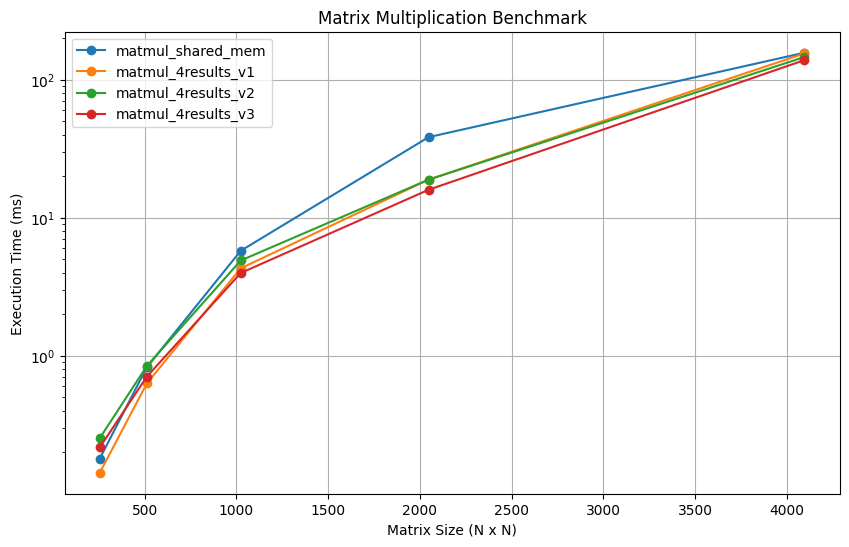

In [22]:
matrix_processor.run_benchmark(exclude=["numba_matmul_basic"])

In [15]:
matrix_processor.profile_gpu_implementation("matmul_4results_v3")

Check profiling/ncu_matmul_4results_v3.ncu-rep for profiling results.


Depending on the implemented strategy, the execution time differs slightly. The benchmark shown below was performed on an NVIDIA T4 GPU:

![GPU Benchmark](img/06_benchmark_versions.png)

The roofline chart looks different: we have increased the Arithmetic Intensity and shifted further to the right. While performance has improved compared to previous implementations, we are still not achieving peak performance. This indicates that, although our optimizations are effective, there remains significant headroom for further improvements in computational efficiency and hardware utilization.

![GPU roofline](img/07_roofline_4results.png)

The memory chart clearly reflects the impact of our algorithmic changes. By optimizing the kernel to increase arithmetic intensity and improve data locality, we significantly reduce the volume of data transferred from global memory to L2 and from L2 to L1 cache. This reduction in memory traffic demonstrates more efficient utilization of the GPU memory hierarchy, contributing to improved overall performance.

![GPU Memory](img/08_memory_4results.png)

### Task 6: Matrix Multiplication Using 2 Tiles from Matrix A and 2 Tiles from Matrix B

In this task, you are required to implement a new GPU kernel that utilizes two tiles from matrix A and two tiles from matrix B per thread block. This approach enables further data reuse, as each tile loaded into shared memory can be leveraged by multiple threads, thereby reducing global memory accesses and increasing overall performance.

Within these four tiles, you can compute four results per thread, as in previous implementations, or you may opt to calculate even more results per thread by using a smaller thread block. By carefully selecting the shapes and sizes of your tiles and thread blocks, you can further optimize memory bandwidth and computational throughput.

```python
@cuda.jit
def cuda_matmul_4tiles(matrixA, matrixB, matrixC, size):
    # ToDo

def matmul_4tiles(matrixA, matrixB, matrixC, size):
    #ToDo

matrix_processor.add_implementation(matmul_4tiles, mem_type="cuda")
matrix_processor.run_implementation("matmul_4tiles", validate=True)
```

The impact of these optimizations is clearly reflected in the benchmark results. For example, the `4tiles_v1` kernel computes four results per thread, while the `4tiles_v2` kernel computes sixteen results per thread within the same four tiles. The performance differences between these approaches are substantial, demonstrating the effectiveness of increased data reuse and workload per thread in maximizing GPU efficiency.

![GPU Benchmark 4 Tiles](img/09_benchmark_4tiles.png)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie19.PNG)

In [6]:
@cuda.jit
def cuda_matmul_4tiles_v1(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB."""
    sAupper = cuda.shared.array((32, 32), dtype=float32)
    sAlower = cuda.shared.array((32, 32), dtype=float32)
    sBleft = cuda.shared.array((32, 32), dtype=float32)
    sBright = cuda.shared.array((32, 32), dtype=float32)
    
    x = cuda.blockIdx.x * 64 + cuda.threadIdx.x
    y = cuda.blockIdx.y * 64 + cuda.threadIdx.y
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    tmp = cuda.local.array((4), float32)
    for i in range(size//32):
        # Preload data into shared memory
        sAupper[ty, tx] = matrixA[y, tx + i * 32]
        sAlower[ty, tx] = matrixA[y + 32, tx + i * 32]
        sBleft[ty, tx] = matrixB[ty + i * 32, x]
        sBright[ty, tx] = matrixB[ty + i * 32, x + 32]
        cuda.syncthreads()

        # Computes 4 partial product on the shared memory
        for j in range(32):
            tmp[0] += sAupper[ty, j] * sBleft[j, tx]
            tmp[1] += sAupper[ty, j] * sBright[j, tx]
            tmp[2] += sAlower[ty, j] * sBright[j, tx]
            tmp[3] += sAlower[ty, j] * sBleft[j, tx]
        cuda.syncthreads()
    
    cuda.syncthreads()
    matrixC[y, x] = tmp[0]
    matrixC[y, x+32] = tmp[1]
    matrixC[y+32, x+32] = tmp[2]
    matrixC[y+32, x] = tmp[3]

def matmul_4tiles_v1(matrixA, matrixB, matrixC, size):
    """Use 8192 bytes of shared memory (32x32 tile size) for matrix multiplication."""
    cuda_matmul_4tiles_v1[(size//32//2, size//32//2), (32, 32)](matrixA, matrixB, matrixC, size)

matrix_processor.add_implementation(matmul_4tiles_v1, mem_type="cuda")
matrix_processor.run_implementation("matmul_4tiles_v1", validate=True, mean_time=True)

First execution of matmul_4tiles_v1 took: 259.141ms.
Mean execution time of matmul_4tiles_v1 is: 3.897ms.


In [7]:
@cuda.jit
def cuda_matmul_4tiles_v2(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB."""
    smem = cuda.shared.array(0, dtype=float32)
    sAupper = smem[:1024].reshape(32, 32)
    sAlower = smem[1024 : 2048].reshape(32, 32)
    sBleft = smem[2048 : 3072].reshape(32, 32)
    sBright = smem[3072 : 4096].reshape(32, 32)
   
    x = cuda.blockIdx.x * 64 + cuda.threadIdx.x
    y = cuda.blockIdx.y * 64 + cuda.threadIdx.y
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    tmpUpperLeft = cuda.local.array(4, float32)
    tmpUpperRight = cuda.local.array(4, float32)
    tmpLowerLeft = cuda.local.array(4, float32)
    tmpLowerRight = cuda.local.array(4, float32)
    for i in range(size//32):
        # Preload data into shared memory
        sAupper[ty, tx] = matrixA[y, tx + i * 32]
        sAupper[ty+8, tx] = matrixA[y+8, tx + i * 32]
        sAupper[ty+16, tx] = matrixA[y+16, tx + i * 32]
        sAupper[ty+24, tx] = matrixA[y+24, tx + i * 32]
        sAlower[ty, tx] = matrixA[y+32, tx + i * 32]
        sAlower[ty+8, tx] = matrixA[y+40, tx + i * 32]
        sAlower[ty+16, tx] = matrixA[y+48, tx + i * 32]
        sAlower[ty+24, tx] = matrixA[y+56, tx + i * 32]
        sBleft[ty, tx] = matrixB[ty + i * 32, x]
        sBleft[ty+8, tx] = matrixB[ty+8 + i * 32, x]
        sBleft[ty+16, tx] = matrixB[ty+16 + i * 32, x]
        sBleft[ty+24, tx] = matrixB[ty+24 + i * 32, x]
        sBright[ty, tx] = matrixB[ty + i * 32, x+32]
        sBright[ty+8, tx] = matrixB[ty+8 + i * 32, x+32]
        sBright[ty+16, tx] = matrixB[ty+16 + i * 32, x+32]
        sBright[ty+24, tx] = matrixB[ty+24 + i * 32, x+32]
        cuda.syncthreads()

        # Computes 4 partial products on 4 tiles (so total of 16) on the shared memory
        for j in range(32):
            tmpUpperLeft[0] += sAupper[ty, j] * sBleft[j, tx]
            tmpUpperLeft[1] += sAupper[ty+8, j] * sBleft[j, tx]
            tmpUpperLeft[2] += sAupper[ty+16, j] * sBleft[j, tx]
            tmpUpperLeft[3] += sAupper[ty+24, j] * sBleft[j, tx]
            tmpUpperRight[0] += sAupper[ty, j] * sBright[j, tx]
            tmpUpperRight[1] += sAupper[ty+8, j] * sBright[j, tx]
            tmpUpperRight[2] += sAupper[ty+16, j] * sBright[j, tx]
            tmpUpperRight[3] += sAupper[ty+24, j] * sBright[j, tx]
            tmpLowerRight[0] += sAlower[ty, j] * sBright[j, tx]
            tmpLowerRight[1] += sAlower[ty+8, j] * sBright[j, tx]
            tmpLowerRight[2] += sAlower[ty+16, j] * sBright[j, tx]
            tmpLowerRight[3] += sAlower[ty+24, j] * sBright[j, tx]
            tmpLowerLeft[0] += sAlower[ty, j] * sBleft[j, tx]
            tmpLowerLeft[1] += sAlower[ty+8, j] * sBleft[j, tx]
            tmpLowerLeft[2] += sAlower[ty+16, j] * sBleft[j, tx]
            tmpLowerLeft[3] += sAlower[ty+24, j] * sBleft[j, tx]
        cuda.syncthreads()

    matrixC[y, x] = tmpUpperLeft[0]
    matrixC[y+8, x] = tmpUpperLeft[1]
    matrixC[y+16, x] = tmpUpperLeft[2]
    matrixC[y+24, x] = tmpUpperLeft[3]
    matrixC[y, x+32] = tmpUpperRight[0]
    matrixC[y+8, x+32] = tmpUpperRight[1]
    matrixC[y+16, x+32] = tmpUpperRight[2]
    matrixC[y+24, x+32] = tmpUpperRight[3]
    matrixC[y+32, x] = tmpLowerLeft[0]
    matrixC[y+40, x] = tmpLowerLeft[1]
    matrixC[y+48, x] = tmpLowerLeft[2]
    matrixC[y+56, x] = tmpLowerLeft[3]
    matrixC[y+32, x+32] = tmpLowerRight[0]
    matrixC[y+40, x+32] = tmpLowerRight[1]
    matrixC[y+48, x+32] = tmpLowerRight[2]
    matrixC[y+56, x+32] = tmpLowerRight[3]


def matmul_4tiles_v2(matrixA, matrixB, matrixC, size):
    """Use 8192 bytes of shared memory (32x32 tile size) for matrix multiplication."""
    cuda_matmul_4tiles_v2[(size//64, size//64), (32,32//4), 0, 16384](matrixA, matrixB, matrixC, size)

matrix_processor.add_implementation(matmul_4tiles_v2, mem_type="cuda")
matrix_processor.run_implementation("matmul_4tiles_v2", validate=True)

First execution of matmul_4tiles_v2 took: 1236.657ms.
Mean execution time of matmul_4tiles_v2 is: 2.533ms.


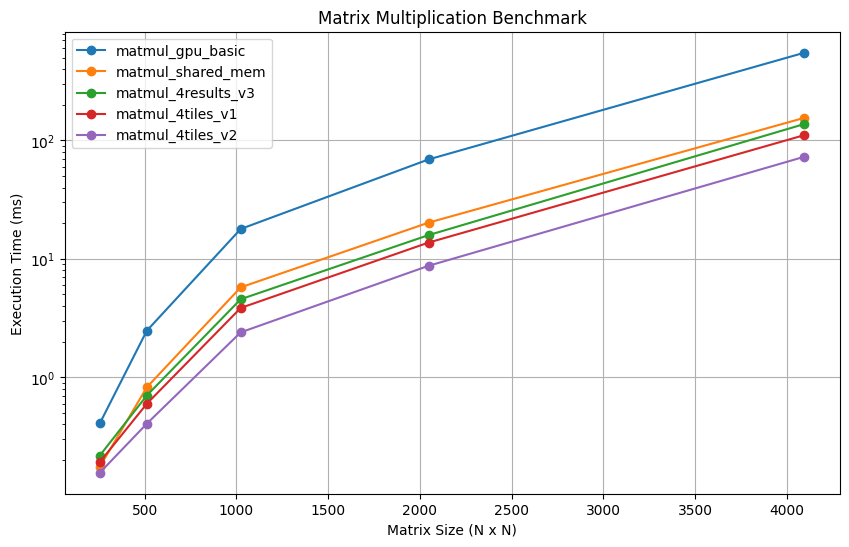

In [ ]:
matrix_processor.run_benchmark(exclude=["numba_matmul_basic"])

In [12]:
matrix_processor.profile_gpu_implementation("matmul_4tiles_v2")

Check profiling/ncu_matmul_4tiles_v2.ncu-rep for profiling results.
==PROF== Connected to process 41356 (/usr/bin/python3.12)
==PROF== Profiling "cuda_matmul_4tiles_v2[abi:v1,..." - 0: 0%.
==WARNING== Launching the workload is taking more time than expected. If this continues to hang, terminate the profile and re-try by profiling the range of all related launches using '--replay-mode range'. See https://docs.nvidia.com/nsight-compute/ProfilingGuide/index.html#replay for more details.
...50%....100% - 28 passes
First execution of matmul_4tiles_v2 took: 13487.080ms.
==PROF== Disconnected from process 41356
==PROF== Report: /home/azureuser/src/HS25/02_Python_CUDA/profiling/ncu_matmul_4tiles_v2.ncu-rep




This marks the conclusion of our matrix multiplication journey using Numba CUDA. As evidenced by the roofline chart, we are finally approaching the horizontal roof, indicating significant progress toward peak hardware utilization. 

![GPU Roofline Basic](img/12_roofline_4tiles.png)

Achieving true peak performance, however, would require leveraging additional low-level features such as vectorized load/store operations, warp-level primitives, and even inline PTX code to optimize critical sections beyond what the compiler can achieve. If you are interested in mastering these advanced techniques, consider enrolling in the "Parallel Computing (pac)" course at FHNW, where you will gain hands-on experience with CUDA C++, low-level optimization, and parallel algorithm design.

For most practical applications, however, peak performance can be attained without delving into intricate low-level programming. The key is to utilize the robust GPU/CUDA ecosystem already available. Up to this point, we have primarily operated at the library layer, with Numba serving as both a framework and a library. For high-performance mathematical computations, it is advisable to rely on established CUDA Math Libraries—such as cuBLAS for matrix multiplication. To demonstrate this, we will now transition from Numba to CuPy, which provides a `.dot` function that internally utilizes cuBLAS for optimal performance.

![GPU Ecosystem](img/13_ecosystem.png)
(Image credits: https://blogs.nvidia.com/blog/what-is-cuda-2/)

### Task 7: Matrix Multiplication Using CuPy's `.dot` Function

In this task, we implement matrix multiplication leveraging CuPy's highly optimized `.dot` function, which internally utilizes the cuBLAS library for maximum performance on NVIDIA GPUs. After executing and profiling this approach, we compare its performance against our best custom GPU implementation. This comparison provides valuable insights into the efficiency of hand-optimized kernels versus state-of-the-art library routines, highlighting the benefits of utilizing established GPU-accelerated libraries for computationally intensive tasks.

```python
def matmul_cupy(matrixA, matrixB, matrixC, size):
    #ToDo

matrix_processor.add_implementation(matmul_cupy, mem_type="cuda")
matrix_processor.run_implementation("matmul_cupy", validate=True)
```

In [8]:
def matmul_cupy(matrixA, matrixB, matrixC, size):
    """Use cupy.dot (which is using CuBLAS unde rthe hood) to have the most efficient implementation."""
    cupy.dot(matrixA, matrixB, out=matrixC)

matrix_processor.add_implementation(matmul_cupy, mem_type="cupy")
matrix_processor.run_implementation("matmul_cupy", validate=True)

First execution of matmul_cupy took: 45.330ms.
Mean execution time of matmul_cupy is: 0.886ms.


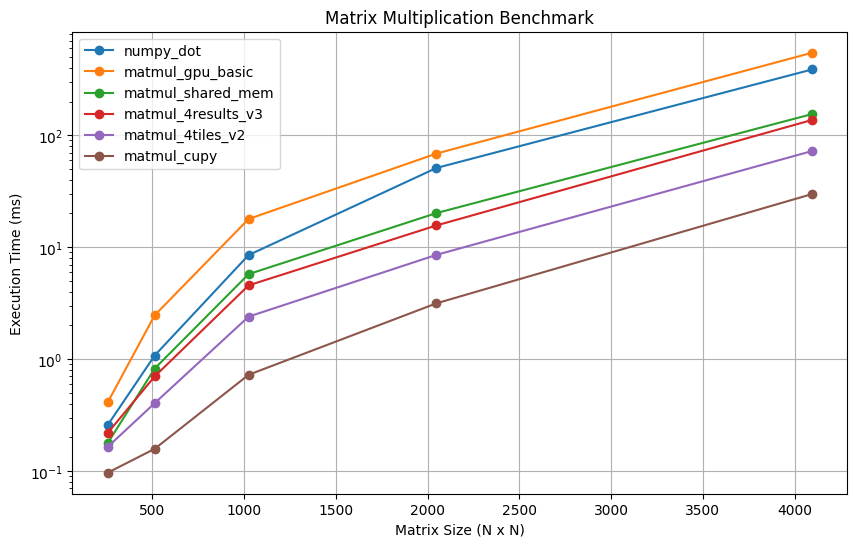

In [9]:
matrix_processor.run_benchmark(exclude=["numba_matmul_basic"])

In [18]:
matrix_processor.profile_gpu_implementation("matmul_cupy", debug=True)

Check profiling/ncu_matmul_cupy.ncu-rep for profiling results.
==PROF== Connected to process 40829 (/usr/bin/python3.12)
==PROF== Profiling "volta_sgemm_128x64_nn" - 0: 0%....50%....100% - 28 passes
First execution of matmul_cupy took: 8761.614ms.
==PROF== Disconnected from process 40829
==PROF== Report: /home/azureuser/src/HS25/02_Python_CUDA/profiling/ncu_matmul_cupy.ncu-rep




Looking at the profiling of the CuPy `dot` function, we observe that the kernel achieves peak FP32 performance. Furthermore, data transfers from global memory are further reduced, and the most utilized pipeline on the GPU is now the Fused Multiply-Add (FMA) unit rather than the Load/Store Unit (LSU). This indicates highly efficient use of both computational and memory resources, demonstrating the effectiveness of leveraging optimized library routines for matrix multiplication on the GPU.

![GPU Roofline CuPy](img/10_roofline_cupy.png)

Let us return to the roofline performance model. Thus far, our discussion has centered on CUDA-enabled NVIDIA GPUs. However, the high-performance computing (HPC) landscape encompasses a wide range of architectures, with NVIDIA GPUs representing only a portion of the ecosystem. The following slides provide a comprehensive overview of HPC platform characteristics and their implications within the context of the roofline model.

![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie20.PNG)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie21.PNG)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie22.PNG)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie23.PNG)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie24.PNG)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie25.PNG)
![GPU matrix multiplication & roofline](img/02_GPU_Matrix/Folie26.PNG)